In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

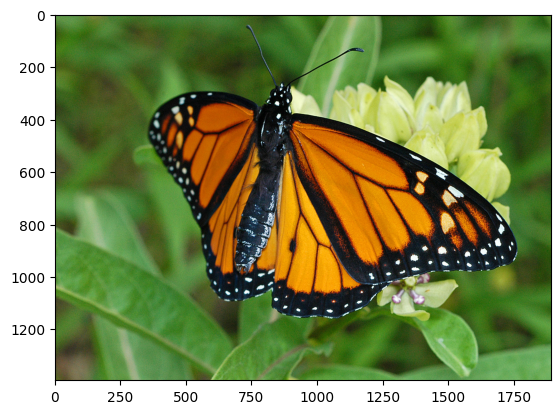

In [ ]:

imBRG = cv2.imread("/content/drive/MyDrive/UET_Master/XLTHSNC/0010027.png")
imRGB =cv2.cvtColor(imBRG, cv2.COLOR_BGR2RGB)
plt.imshow(imRGB)
plt.show()

In [ ]:
def calculate_psnr(img1, img2, max_value=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * math.log10(max_value**2 / mse)

def add_gaussian_noise_psnr(image, target_psnr, max_intensity=1.0):
    sigma_squared = (max_intensity**2) / (10**(target_psnr / 10.0))
    sigma = np.sqrt(sigma_squared)

    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0.0, max_intensity)

    return noisy_image

In [ ]:
image_path = '/content/drive/MyDrive/UET_Master/XLTHSNC/0010027.png'
kernel_size = 20
kernel_sigma = 5
psnr_levels_db = [10, 20, 25, 30]
img_original = cv2.imread(image_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
img_norm = img_original.astype(np.float32) / 255.0
max_pixel_value = 1.0


In [ ]:
gaussian_kernel_1d = cv2.getGaussianKernel(kernel_size, kernel_sigma)
gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d.transpose())
gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)
kernel = gaussian_kernel_2d

img_blurred = cv2.filter2D(img_norm, -1, kernel)
img_blurred = np.clip(img_blurred, 0.0, max_pixel_value)

noisy_images = {}
actual_psnrs = {}
for psnr_db in psnr_levels_db:
    noisy_img = add_gaussian_noise_psnr(img_blurred, psnr_db, max_pixel_value)
    noisy_images[psnr_db] = noisy_img
    actual_psnrs[psnr_db] = calculate_psnr(img_norm, noisy_img, max_pixel_value)

(np.float64(-0.5), np.float64(1892.5), np.float64(1394.5), np.float64(-0.5))

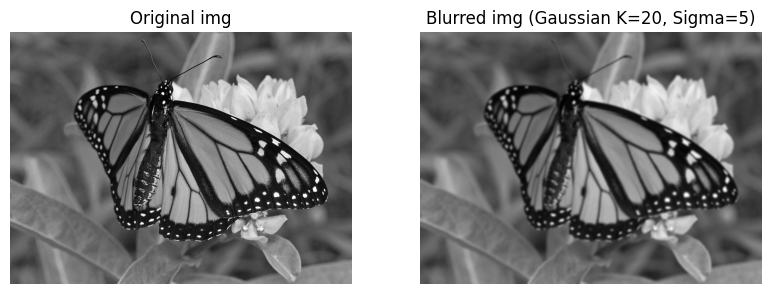

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_norm, cmap='gray')
plt.title('Original img')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(img_blurred, cmap='gray')
plt.title(f'Blurred img (Gaussian K={kernel_size}, Sigma={kernel_sigma})')
plt.axis('off')

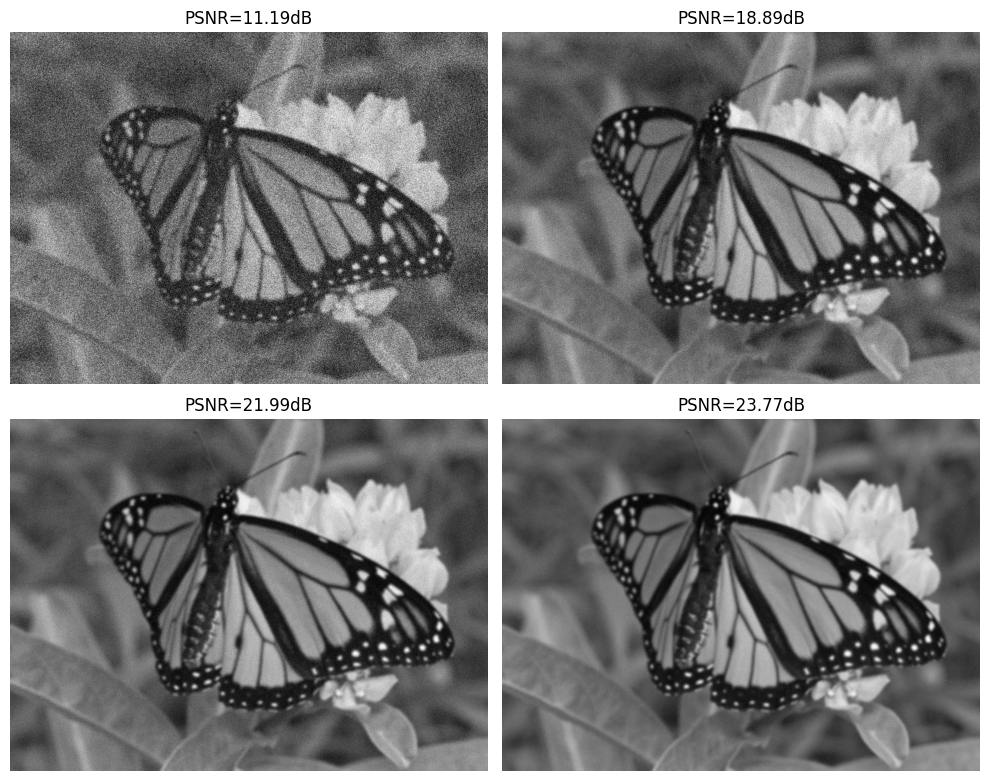

In [ ]:
plt.figure(figsize=(10, 8))

for i, psnr_db in enumerate(psnr_levels_db):
    plt.subplot(2, 2, i + 1)
    plt.imshow(noisy_images[psnr_db], cmap='gray')
    plt.title(f'PSNR={actual_psnrs[psnr_db]:.2f}dB')
    plt.axis('off')

plt.tight_layout()
plt.show()

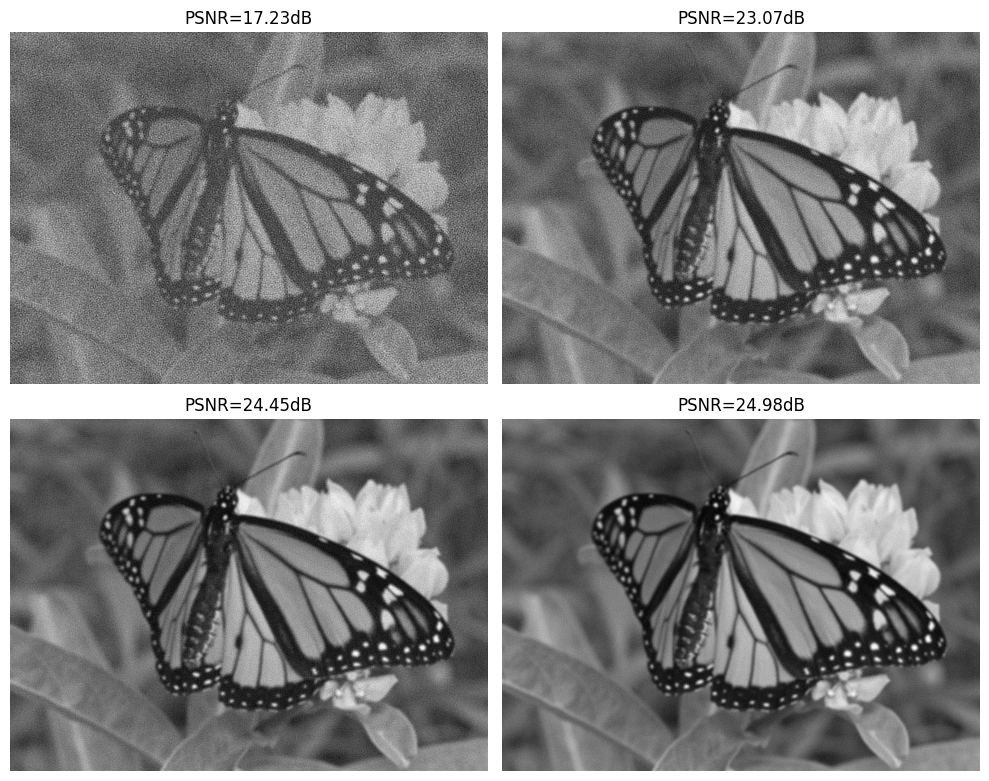

In [ ]:
#Inverse filtering
def create_gaussian_kernel(ksize, sigma):
    if not (isinstance(ksize, tuple) and len(ksize) == 2 and
            ksize[0] > 0 and ksize[1] > 0 and
            ksize[0] % 2 == 1 and ksize[1] % 2 == 1):
      raise ValueError("Error")
    if sigma <= 0:
        raise ValueError("Error")
    rows, cols = ksize
    center_r, center_c = rows // 2, cols // 2
    x, y = np.meshgrid(np.arange(cols) - center_c, np.arange(rows) - center_r)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def inverse_filter_restore(blurred_noisy_image, psf_kernel, epsilon=1e-3):
    g = blurred_noisy_image.astype(np.float64)
    rows, cols = g.shape

    k_rows, k_cols = psf_kernel.shape
    h_padded = np.zeros_like(g)
    r_start = rows // 2 - k_rows // 2
    r_end = r_start + k_rows
    c_start = cols // 2 - k_cols // 2
    c_end = c_start + k_cols
    h_padded[r_start:r_end, c_start:c_end] = psf_kernel
    h_shifted = np.fft.ifftshift(h_padded)


    G = np.fft.fft2(g)
    H = np.fft.fft2(h_shifted)

    idx_small_H = np.abs(H) < epsilon
    Inv_H = np.divide(1.0, H, where=~idx_small_H, out=np.zeros_like(H))
    Inv_H[idx_small_H] = 0
    F_est = G * Inv_H

    f_est_complex = np.fft.ifft2(F_est)

    f_est = np.real(f_est_complex)
    return f_est

original_blur_type = 'gauss' #'avg', 'motion'
original_blur_ksize = (15, 15)
original_blur_sigma = 2.0
epsilon_value = 3e-1
psf = create_gaussian_kernel(original_blur_ksize, original_blur_sigma)
inverse_restored_images = []
inverse_actual_psnrs = []
for noisy_img in noisy_images.values():
    if original_blur_type == 'gauss':
        restored_img = inverse_filter_restore(noisy_img, psf, epsilon=epsilon_value)
        inverse_restored_images.append(restored_img)
        inverse_actual_psnrs.append(calculate_psnr(img_norm, restored_img, max_pixel_value))

plt.figure(figsize=(10, 8))

for i, psnr_db in enumerate(psnr_levels_db):
    plt.subplot(2, 2, i + 1)
    plt.imshow(inverse_restored_images[i], cmap='gray')
    plt.title(f'PSNR={inverse_actual_psnrs[i]:.2f}dB')
    plt.axis('off')

plt.tight_layout()
plt.show()

  Interation 10/100...
  Interation 20/100...
  Interation 30/100...
  Interation 40/100...
  Interation 50/100...
  Interation 60/100...
  Interation 70/100...
  Interation 80/100...
  Interation 90/100...
  Interation 100/100...
Finish Landweber.
  Interation 10/100...
  Interation 20/100...
  Interation 30/100...
  Interation 40/100...
  Interation 50/100...
  Interation 60/100...
  Interation 70/100...
  Interation 80/100...
  Interation 90/100...
  Interation 100/100...
Finish Landweber.
  Interation 10/100...
  Interation 20/100...
  Interation 30/100...
  Interation 40/100...
  Interation 50/100...
  Interation 60/100...
  Interation 70/100...
  Interation 80/100...
  Interation 90/100...
  Interation 100/100...
Finish Landweber.
  Interation 10/100...
  Interation 20/100...
  Interation 30/100...
  Interation 40/100...
  Interation 50/100...
  Interation 60/100...
  Interation 70/100...
  Interation 80/100...
  Interation 90/100...
  Interation 100/100...
Finish Landweber.


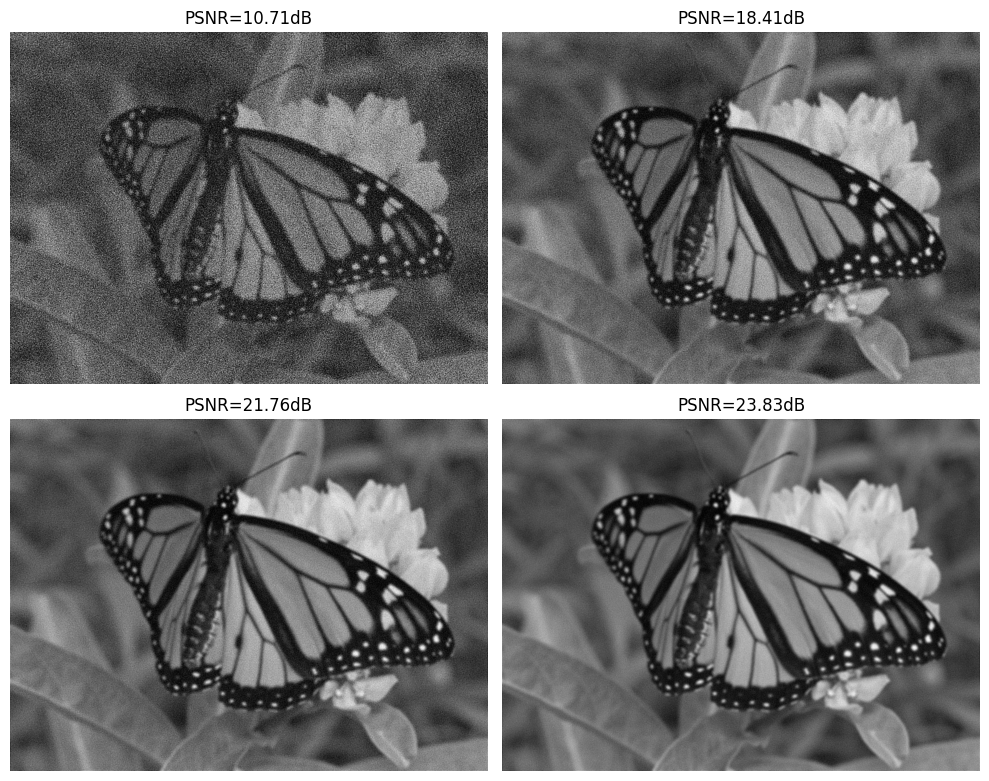

In [ ]:
# Landweber method
def create_gaussian_kernel(ksize, sigma):
  if not (isinstance(ksize, tuple) and len(ksize) == 2 and
          ksize[0] > 0 and ksize[1] > 0 and
          ksize[0] % 2 == 1 and ksize[1] % 2 == 1):
    raise ValueError("Error")
  if sigma <= 0:
      raise ValueError("Error")

  rows, cols = ksize
  center_r, center_c = rows // 2, cols // 2
  x, y = np.meshgrid(np.arange(cols) - center_c, np.arange(rows) - center_r)
  kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
  kernel = kernel / np.sum(kernel)
  return kernel

def landweber_restore(blurred_noisy_image, psf_kernel, num_iters, alpha):

    g = blurred_noisy_image.astype(np.float64) / 255.0
    rows, cols = g.shape

    k_rows, k_cols = psf_kernel.shape
    h_padded = np.zeros_like(g)
    r_start = rows // 2 - k_rows // 2
    r_end = r_start + k_rows
    c_start = cols // 2 - k_cols // 2
    c_end = c_start + k_cols
    h_padded[r_start:r_end, c_start:c_end] = psf_kernel
    h_shifted = np.fft.ifftshift(h_padded)
    H = np.fft.fft2(h_shifted)
    H_conj = np.conjugate(H)


    f_k = g.copy()

    #Landweber
    for k in range(num_iters):
        if (k + 1) % 10 == 0:
            print(f"  Interation {k+1}/{num_iters}...")

        # h * f_k
        F_k = np.fft.fft2(f_k)
        HF_k = H * F_k
        blurred_f_k = np.real(np.fft.ifft2(HF_k))

        residual = g - blurred_f_k

        # h^T * residual
        # FFT(h^T * residual) = FFT(h^T) * FFT(residual) = H_conj * FFT(residual)
        Residual_fft = np.fft.fft2(residual)
        H_conj_Residual = H_conj * Residual_fft
        correction_term = np.real(np.fft.ifft2(H_conj_Residual))

        f_k_plus_1 = f_k + alpha * correction_term


        f_k = np.clip(f_k_plus_1, 0, 1)


    print("Finish Landweber.")
    return f_k * 255.0

original_blur_ksize = (15, 15)
original_blur_sigma = 2.0
num_iterations =  100
alpha_value = 0.05
psf = create_gaussian_kernel(original_blur_ksize, original_blur_sigma)
landweber_restored_images = []
landweber_actual_psnrs = []
for noisy_img in noisy_images.values():
    if original_blur_type == 'gauss':
        restored_img = landweber_restore(noisy_img, psf, num_iterations, alpha_value)
        landweber_restored_images.append(restored_img)
        landweber_actual_psnrs.append(calculate_psnr(img_norm, restored_img, max_pixel_value))

plt.figure(figsize=(10, 8))

for i, psnr_db in enumerate(psnr_levels_db):
    plt.subplot(2, 2, i + 1)
    plt.imshow(landweber_restored_images[i], cmap='gray')
    plt.title(f'PSNR={landweber_actual_psnrs[i]:.2f}dB')
    plt.axis('off')

plt.tight_layout()
plt.show()

Finish Wiener Filter.
Finish Wiener Filter.
Finish Wiener Filter.
Finish Wiener Filter.


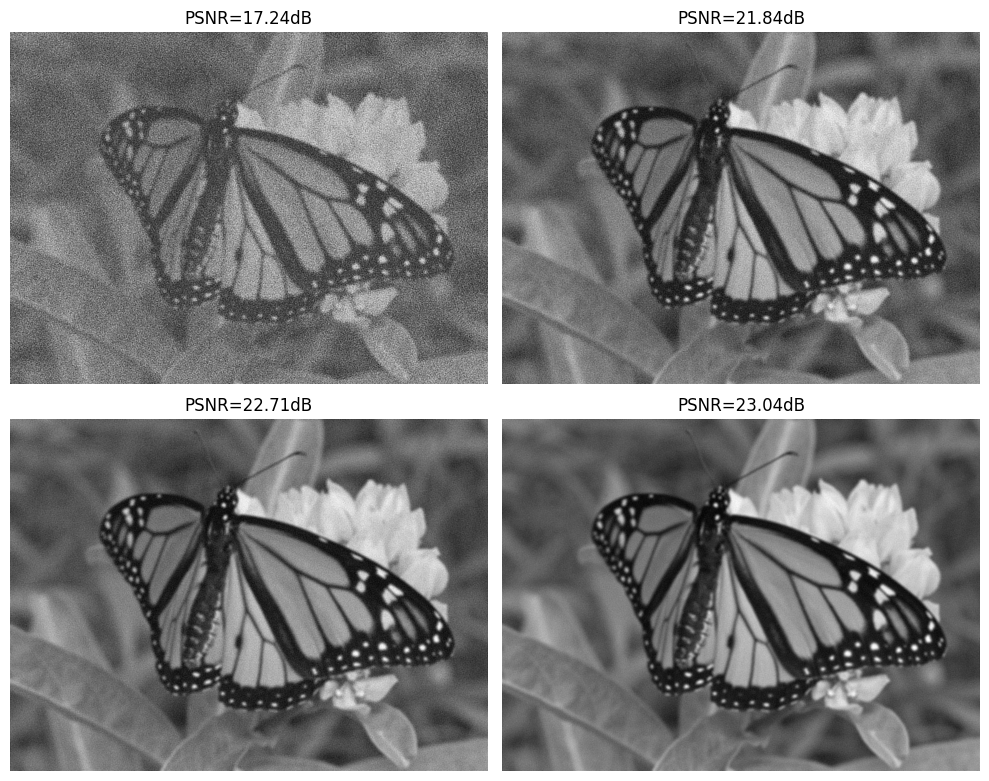

In [ ]:
# Wiener method
def create_gaussian_kernel(ksize, sigma):
    if not (isinstance(ksize, tuple) and len(ksize) == 2 and
            ksize[0] > 0 and ksize[1] > 0 and
            ksize[0] % 2 == 1 and ksize[1] % 2 == 1):
      raise ValueError("Error")
    if sigma <= 0:
        raise ValueError("Error")

    rows, cols = ksize
    center_r, center_c = rows // 2, cols // 2
    x, y = np.meshgrid(np.arange(cols) - center_c, np.arange(rows) - center_r)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def wiener_filter_restore(blurred_noisy_image, psf_kernel, K):

    g = blurred_noisy_image.astype(np.float64)
    rows, cols = g.shape

    k_rows, k_cols = psf_kernel.shape
    h_padded = np.zeros_like(g)
    r_start = rows // 2 - k_rows // 2
    r_end = r_start + k_rows
    c_start = cols // 2 - k_cols // 2
    c_end = c_start + k_cols
    h_padded[r_start:r_end, c_start:c_end] = psf_kernel

    h_shifted = np.fft.ifftshift(h_padded)


    G = np.fft.fft2(g)
    H = np.fft.fft2(h_shifted)


    H_conj = np.conjugate(H)
    H_mag_sq = np.abs(H)**2


    # Wiener_Filter = H_conj / (H_mag_sq + K)
    denominator = H_mag_sq + K

    # safe_denominator = np.where(denominator == 0, 1e-10, denominator)
    wiener_filter_freq = H_conj / denominator


    F_est_freq = wiener_filter_freq * G


    f_est_complex = np.fft.ifft2(F_est_freq)

    f_est = np.real(f_est_complex)

    print("Finish Wiener Filter.")
    return f_est
original_blur_ksize = (15, 15)
original_blur_sigma = 2.0
K_value = 0.1
psf = create_gaussian_kernel(original_blur_ksize, original_blur_sigma)
wiener_restored_images = []
wiener_actual_psnrs = []
for noisy_img in noisy_images.values():
    if original_blur_type == 'gauss':
        restored_img = wiener_filter_restore(noisy_img, psf, K_value)
        wiener_restored_images.append(restored_img)
        wiener_actual_psnrs.append(calculate_psnr(img_norm, restored_img, max_pixel_value))

plt.figure(figsize=(10, 8))

for i, psnr_db in enumerate(psnr_levels_db):
    plt.subplot(2, 2, i + 1)
    plt.imshow(wiener_restored_images[i], cmap='gray')
    plt.title(f'PSNR={wiener_actual_psnrs[i]:.2f}dB')
    plt.axis('off')

plt.tight_layout()
plt.show()